In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from skimage.feature import hog
from skimage import exposure
from skimage.transform import rotate
import pickle
from tqdm import tqdm
import timeit
from joblib import Parallel, delayed
import os


In [2]:
def save_pickle(data, filename):
    '''
        Write data to pickle file
    '''
    pickle.dump(data, open(filename, 'wb'))

def load_pickle(filename):
    """
        Load data from pickle file
    """
    return pickle.load(open(filename, 'rb'))

In [3]:
def show_image_by_range(pixels, labels, start=0, end=1, img_size=28):
    """
        Show images in range from start to end.
    """
    pixels_tmp = pixels.reshape(-1, img_size, img_size, 1)
    plt.figure(figsize=(12, 12))

    for i in range(start, end):
        plt.subplot((end - start) // 4 + 1, 4, i + 1)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(pixels_tmp[i, :, :, 0], cmap='gray')

    plt.show()

def show_image_by_condition(pixels, labels, label_condition=None, numbers=24, img_size=28):
    """
        Show images by label
    """
    pixels_tmp = pixels.reshape(-1, img_size, img_size, 1)
    plt.figure(figsize=(12, 12))

    cnt = 0
    if label_condition is None:
        label_condition_set = set(np.unique(y_train))
    else:
        label_condition_set = set(label_condition)

    n_images = len(pixels)
    n_condition = len(label_condition_set)
    cached_label = set()
    while cnt < numbers:
        idx = np.random.randint(0, n_images)
        if labels[idx] in label_condition_set and (labels[idx] not in cached_label or cnt >= n_condition):
            cnt += 1
            cached_label.add(labels[idx])
            plt.subplot(numbers // 4 + 1, 4, cnt)
            plt.axis('off')
            plt.title(labels[idx])
            plt.imshow(pixels_tmp[idx, :, :, 0], cmap='gray')

    plt.show()

(27455, 784) (27455,) (7172, 784) (7172,)


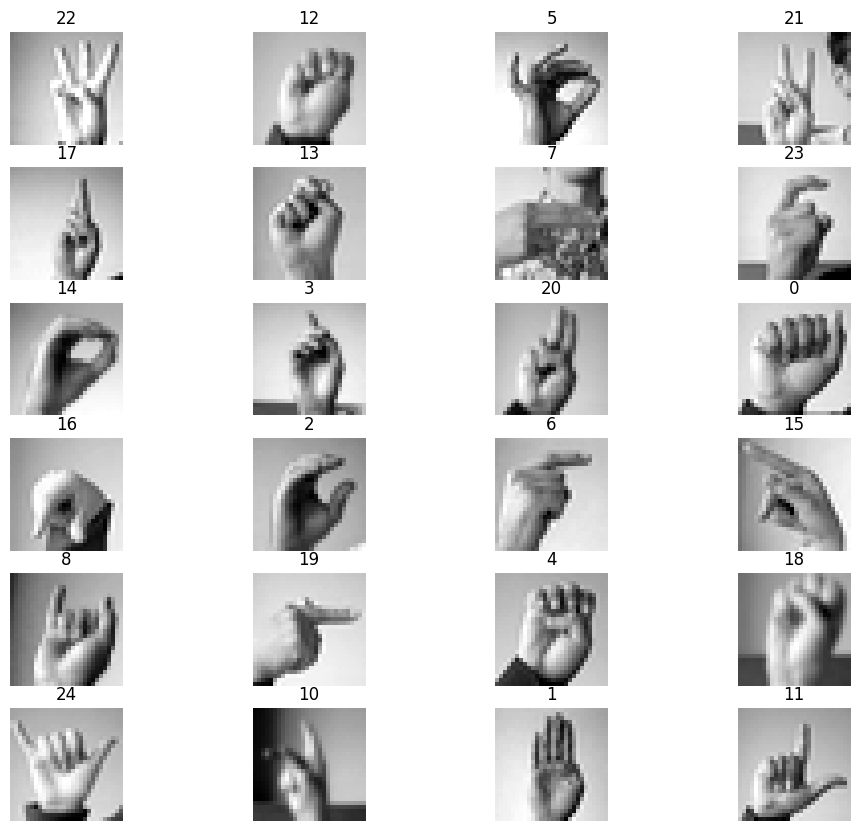

In [4]:
# read data from csv file
dfTrain = pd.read_csv('archive/sign_mnist_train/sign_mnist_train.csv')
dfTest = pd.read_csv('archive/sign_mnist_test/sign_mnist_test.csv')

# split data into X and y
X_train = dfTrain.drop('label', axis=1).values
y_train = dfTrain['label'].values
X_test = dfTest.drop('label', axis=1).values
y_test = dfTest['label'].values
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
# normalize data from 0 to 1 range 
X_train = X_train / 255.0
X_test = X_test / 255.0

# Visualize images
show_image_by_condition(X_train, y_train, numbers=24)

In [5]:
X_train_hist, y_train_hist = np.copy(X_train), np.copy(y_train)

In [6]:
def extract_hog(img, img_size=28, orientations=9, pixels_per_cell=(2, 6), cells_per_block=(1, 1)):
    """
        Histogram of Oriented Gradients
    """
    fd = hog(img.reshape((img_size, img_size)), orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=False)

    return fd

def call_parallel_extraction(images):
    """
        Process images parallelly
    """
    features = Parallel(n_jobs=os.cpu_count())(delayed(extract_hog)(img) for img in tqdm(images))
    return np.array(features)

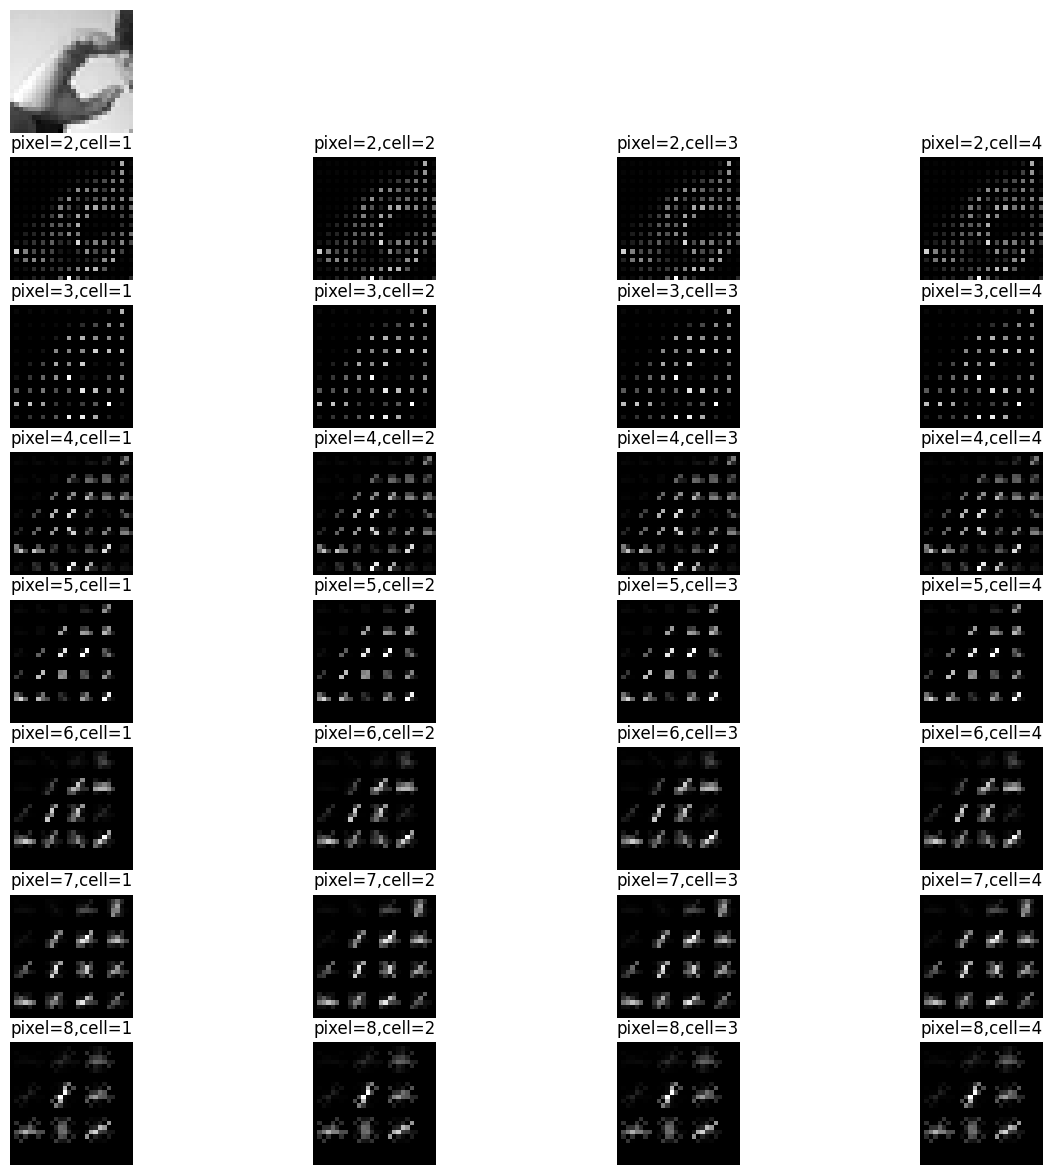

In [7]:
# Show hog features
represent_index = 3
plt.figure(figsize=(15, 15))
plt.subplot(8, 4, 1)
plt.imshow(X_train[represent_index].reshape(28, 28), cmap='gray')
plt.axis('off')
cnt = 2
for n_pixel in range(2, 9):
    for n_cell in range(1, 5):
        _, represent_hog = hog(X_train[represent_index].reshape((28, 28)), \
                               orientations=9, pixels_per_cell=(n_pixel, n_pixel), \
                               cells_per_block=(n_cell, n_cell), visualize=True)
        plt.subplot(8, 4, cnt + 3)
        cnt += 1
        plt.title('pixel=' + str(n_pixel) + ',cell=' + str(n_cell))
        plt.imshow(represent_hog, cmap='gray')
        plt.axis('off')
plt.show()

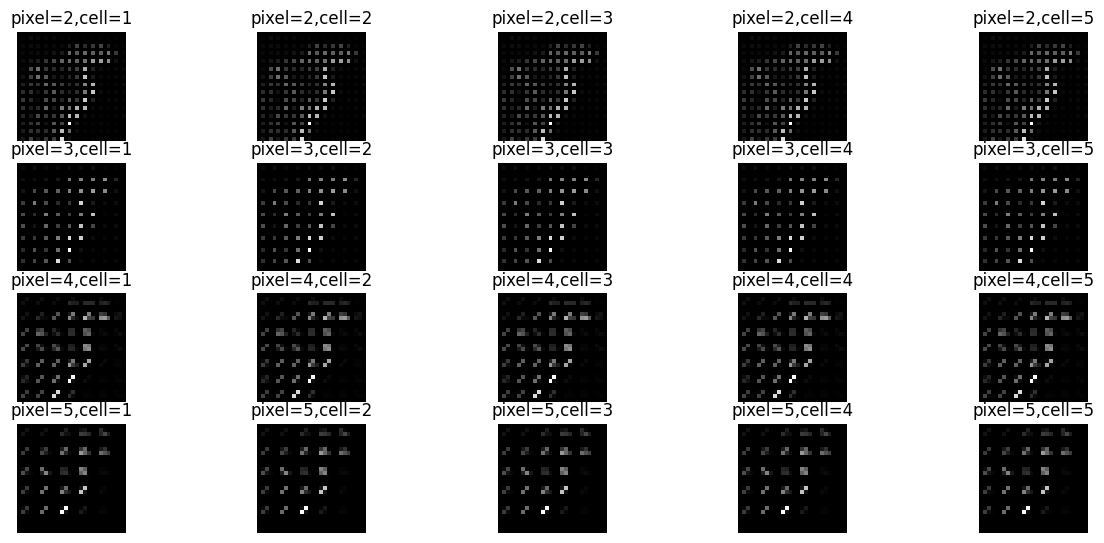

In [8]:
# Show hog features
import random
represent_index = random.randint(0, len(X_train))
plt.figure(figsize=(15, 15))
plt.subplot(9,5, 1)
plt.imshow(X_train[represent_index].reshape(28, 28), cmap='gray')
plt.axis('off')
cnt = 1
for n_pixel in range(2, 6):
    for n_cell in range(1, 6):
        _, represent_hog = hog(X_train[represent_index].reshape((28, 28)), \
                               orientations=9, pixels_per_cell=(n_pixel, n_pixel), \
                               cells_per_block=(n_cell, n_cell), visualize=True)
        plt.subplot(9, 5, cnt)
        cnt += 1
        plt.title('pixel=' + str(n_pixel) + ',cell=' + str(n_cell))
        plt.imshow(represent_hog, cmap='gray')
        plt.axis('off')
plt.show()


In [9]:
# Features extraction using HOG
X_train_hog = call_parallel_extraction(X_train)
X_test_hog = call_parallel_extraction(X_test)

100%|██████████| 7172/7172 [00:00<00:00, 27720.02it/s]


In [10]:
X_train.shape, X_train_hog.shape, X_test.shape, X_test_hog.shape

((27455, 784), (27455, 504), (7172, 784), (7172, 504))

In [11]:
from sklearn.metrics import accuracy_score,f1_score
from sklearn.ensemble import RandomForestClassifier

# Random Forest
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train_hog, y_train)
# Predict training data
y_train_pred = rf.predict(X_train_hog)
# Predict test data
y_test_pred = rf.predict(X_test_hog)
# Calculate accuracy
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
print('Accuracy on training data: ', accuracy_train)
print('Accuracy on test data: ', accuracy_test)
print('F1 score on training data: ', f1_score(y_train, y_train_pred, average='weighted'))
print('F1 score on test data: ', f1_score(y_test, y_test_pred, average='weighted'))

Accuracy on training data:  1.0
Accuracy on test data:  0.8885945343000557
F1 score on training data:  1.0
F1 score on test data:  0.8902679023635718
